## Chapter 19.1 What is Hyperparameter Optimization?

In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn
from d2l import torch as d2l

In [2]:
class HPOTrainer(d2l.Trainer):
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1 - accuracy / val_batch_idx

In [3]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    data = d2l.FashionMNIST(batch_size=16)
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

       validation_error = 0.22670000791549683


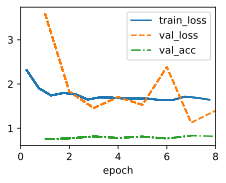

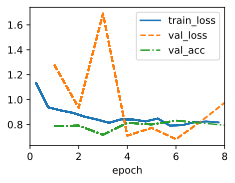

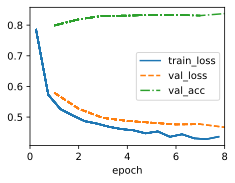

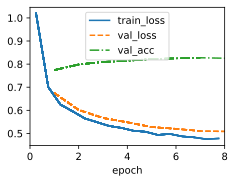

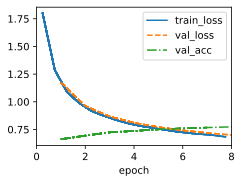

In [5]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f'Trial {i}: learning_rate = {learning_rate}')
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f'       validation_error = {y}')
    values.append(learning_rate)
    errors.append(y)

In [6]:
best_idx = np.argmin(errors)
print(f'optimal learning rate = {values[best_idx]}')

optimal learning rate = 0.012447639190580237


## Chatper 19.2 Hyperparameter Optimization API

In [7]:
import time
from scipy import stats
from d2l import torch as d2l

In [8]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration() -> dict:
        raise NotImplementedError
        
    def update(self, config: dict, error: float, additional_info=None):
        pass

In [9]:
class RandomSearcher(HPOSearcher):
    
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()
        
    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [10]:
class HPOScheduler(d2l.HyperParameters):
    def suggest(self) -> dict:
        raise NotImplementedError
        
    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError

In [11]:
class BasicScheduler(HPOScheduler):
    
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()
        
    def suggest(self) -> dict:
        return self.searcher.sample_configuration()
    
    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, additional_info=info)

In [18]:
class HPOTuner(d2l.HyperParameters):
    
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []
        
    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f'Trial {i}: config = {config}')
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            runtime = time.time() - start_time
            self.bookkeeping(config, error, runtime)
            print(f'      error = {error}, runtime = {runtime}')
            
    def bookkeeping(self, config: dict, error: float, runtime: float):
        self.records.append({'config': config, 'error': error, 'runtime': runtime})
        
        if self.incumbent is None or self.incumbent_error > error:
            self.incumbent = config
            self.incumbent_error = error
            
        self.incumbent_trajectory.append(self.incumbent_error)
        
        self.current_runtime += runtime
        self.cumulative_runtime.append(self.current_runtime)

In [19]:
# Example: Optimizing the Hyperparameters of a CNN

def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [20]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}

initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128
}

      error = 0.2944445013999939, runtime = 55.72446870803833


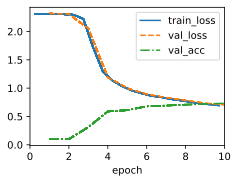

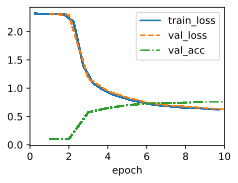

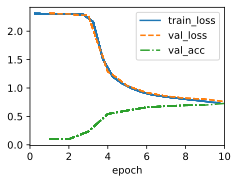

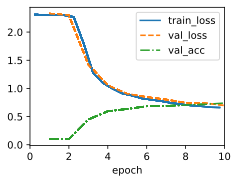

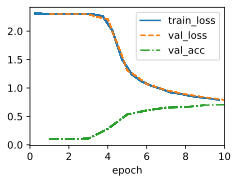

In [21]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

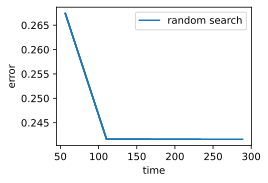

In [22]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip(
    tuner.cumulative_runtime, tuner.incumbent_trajectory):
    board.draw(time_stamp, error, 'random search', every_n=1)

## Chapter 19.3 Asynchronous Random Search

In [24]:
import logging
from d2l import torch as d2l

In [ ]:
# Syne Tune: Large-Scale and Reproducible Hyperparameter Optimization

In [32]:
!pip install -U syne-tune[aws]

In [33]:
logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

ImportError: cannot import name 'PythonBackend' from 'syne_tune.backend.python_backend' (/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/syne_tune/backend/python_backend/__init__.py)

In [34]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import reporter
    from d2l import torch as d2l
    
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))
        

In [35]:
n_workers = 2
max_wallclock_time = 12 * 60

In [36]:
mode = 'min'
metric = 'validation_error'

In [38]:
from syne_tune import StoppingCriterion, Tuner
#from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

INFO:root:SMAC is not imported (not contained in extra) since dependencies are missing. You can install them with
   pip install 'syne-tune[smac]'
or (for almost everything)
   pip install 'syne-tune[basic]'


In [39]:
config_space = {
    'learning_rate': loguniform(1e-2, 1),
    'batch_size': randint(32, 256),
    'max_epochs': 10,
}
initial_config = {
    'learning_rate': 0.1,
    'batch_size': 128,
}

In [40]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

NameError: name 'PythonBackend' is not defined

In [41]:
scheduler = RandomSearch(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 363010734
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


In [42]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)

tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)

NameError: name 'trial_backend' is not defined

In [43]:
tuner.run()

TypeError: HPOTuner.run() missing 1 required positional argument: 'number_of_trials'

In [44]:
d2l.set_figsize()
tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()

AttributeError: 'HPOTuner' object has no attribute 'name'

In [46]:
d2l.set_figsize([6, 2.5])
results = tuning_experiment.results

for trial_id in results.trial_id.unique():
    df = results[results['trial_id'] == trial_id]
    d2l.plt.plot(
        df['st_tuner_time'],
        df['validation_error'],
        marker='o'
    )

d2l.plt.xlabel('wall-clock time')
d2l.plt.ylabel('objective function')

NameError: name 'tuning_experiment' is not defined

In [47]:
Text(0, 0.05, 'objective funtion')

NameError: name 'Text' is not defined

## Chatper 19.4 Multi-Fidelity Hyperparameter Optimization

In [50]:
from collections import defaultdict
import numpy as np
from scipy import stats
from d2l import torch as d2l

d2l.set_figsize()

In [57]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):
    
    def __init__(self, searcher, eta, r_min, r_max, prefact=1):
        self.save_hyperparameters()
        
        self.K = int(np.log(r_max / r_min) / np.log(eta))
        
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]
        if r_max not in self.rung_levels:
            self.rung_levels.append(r_max)
            self.K += 1
            
        self.observed_error_at_rungs = defaultdict(list)
        self.all_observed_error_at_rungs = defaultdict(list)
        
        self.queue = []
        
    def suggest(self):
        if len(self.queue) == 0:
            n0 = int(self.prefact * self.eta ** self.K)
            for _ in range(n0):
                config = self.searcher.sample_configuration()
                config['max_epochs'] = self.r_min
                self.queue.append(config)
            
        return self.queue.pop()
    
    def update(self, config: dict, error: float, info=None):
        ri = int(config['max_epochs'])
        
        self.searcher.update(config, error, additional_info=info)
        self.all_observed_error_at_rungs[ri].append((config, error))
        
        if ri < self.r_max:
            self.observed_error_at_rungs[ri].append((config, error))
            
            ki = self.K - self.rung_levels.index(ri)
            ni = int(self.prefact * self.eta ** ki)
            
            if len(self.observed_error_at_rungs[ri]) >= ni:
                kiplus1 = ki - 1
                niplus1 = int(self.prefact * self.eta ** kiplus1)
                best_performing_configurations = self.get_top_n_configurations(
                    rung_level=ri, n=niplus1
                )
                riplus1 = self.rung_levels[self.K - kiplus1]
                
                self.queue = [
                    dict(config, max_epochs=riplus1)
                    for config in best_performing_configurations
                ] + self.queue
                
                self.observed_error_at_rungs[ri] = []
    
    def get_top_n_configurations(self, rung_level, n):
        rung = self.observed_error_at_rungs[rung_level]
        if not rung:
            return []
        
        sorted_rung = sorted(rung, key=lambda x: x[1])
        return [x[0] for x in sorted_rung[:n]]
                

In [58]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2
num_gpus=1

config_space = {
    'learning_rate': stats.loguniform(1e-2, 1),
    'batch_size': stats.randint(32, 256),
}
initial_config = {
    'learning_rate': 0.1,
    'batch_size': 128,
}

    error = 0.20291954278945923, runtime = 73.09477210044861


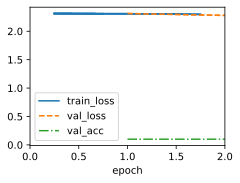

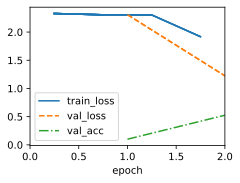

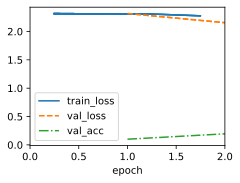

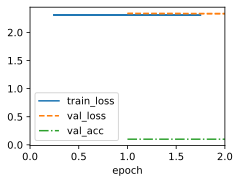

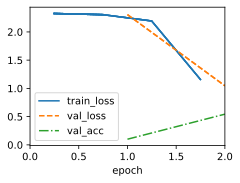

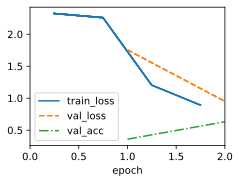

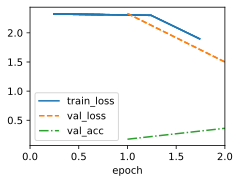

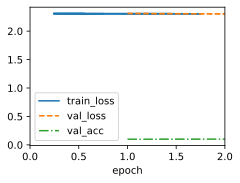

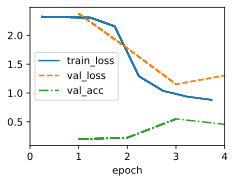

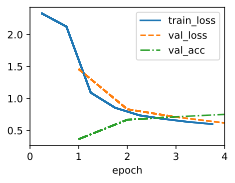

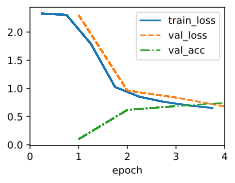

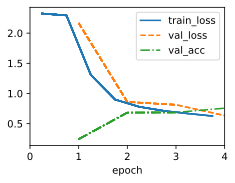

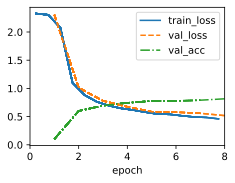

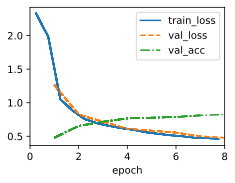

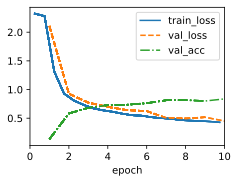

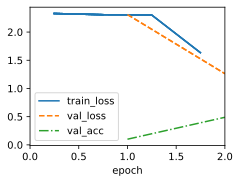

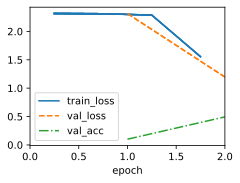

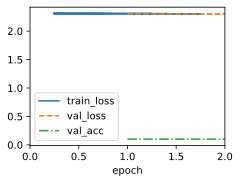

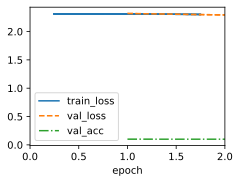

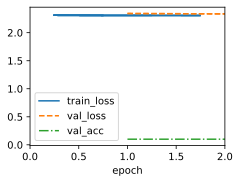

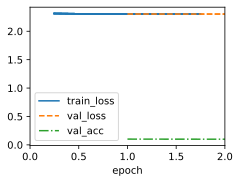

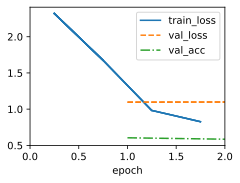

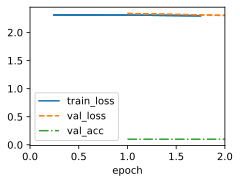

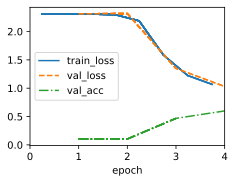

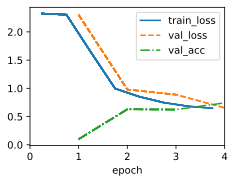

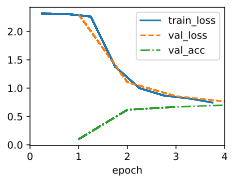

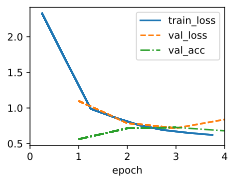

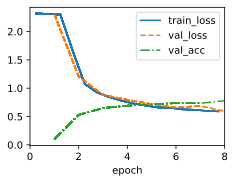

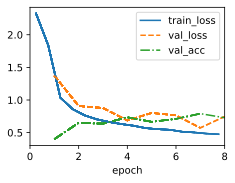

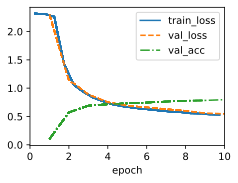

In [60]:
searcher = d2l.RandomSearcher(config_space, initial_config=initial_config)
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,
    eta=eta,
    r_min=min_number_of_epochs,
    r_max=max_number_of_epochs,
)
tuner = d2l.HPOTuner(
    scheduler=scheduler,
    objective=d2l.hpo_objective_lenet,
)
tuner.run(number_of_trials=30)

Text(0.5, 0, 'epochs')

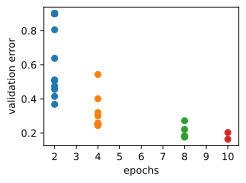

In [63]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    errors = [xi[1] for xi in rung]
    d2l.plt.scatter([rung_index] * len(errors), errors)

d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5)

d2l.plt.xticks(
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
    np.arange(min_number_of_epochs, max_number_of_epochs + 1)
)

d2l.plt.ylabel('validation error')
d2l.plt.xlabel('epochs')

## Chapter 19.5 Asynchronous Successive Halving

In [64]:
import logging
from d2l import torch as d2l

In [74]:
!pip install -U syne-tune[basic,dev]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 8.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 106.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 139.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 12.6 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 75.0 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.12.0
    Uninstalling traitlets-5.12.0:
      Successfully uninstalled traitlets-5.12.0
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: black
    Found existing installation: black 23.10.1
    Uninstalling black-23.10.1:
      Successfully uninstalled black-23.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.38 requires docutils<0.17,>=0.10, but you have docutils 0.20.1 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.3 which is incompatible.


In [76]:
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.optimizer.baselines import ASHA
from syne_tune import Reporter

In [87]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    
    from syne_tune import Reporter
    from d2l import torch as d2l
    
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

In [88]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2

config_space = {
    'learning_rate': loguniform(1e-2, 1),
    'batch_size': randint(32, 256),
    'max_epochs': max_number_of_epochs,
}

initial_config = {
    'learning_rate': 0.1,
    'batch_size': 128,
}

In [89]:
n_workers = 2
max_wallclock_time = 12 * 60

In [90]:
mode = 'min'
metric = 'validation_error'
resource_attr = 'epoch'

scheduler = ASHA(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
    max_resource_attr='max_epochs',
    resource_attr=resource_attr,
    grace_period=min_number_of_epochs,
    reduction_factor=eta,
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 841412351
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


In [91]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)
tuner = Tuner(
    trial_backend = trial_backend,
    scheduler = scheduler,
    stop_criterion = stop_criterion,
    n_workers = n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928
INFO:syne_tune.backend.local_backend:Detected 1 GPUs
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928/tune_function --tune_function_hash b58ac12a4dfb2e58284ea40d71a9df4f --st_checkpoint_dir /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928/0/checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/pyt

INFO:syne_tune.tuner:(trial 11) - scheduled config {'learning_rate': 0.9792127390367618, 'batch_size': 194, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.04990194293811114 --batch_size 63 --max_epochs 10 --tune_function_root /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928/tune_function --tune_function_hash b58ac12a4dfb2e58284ea40d71a9df4f --st_checkpoint_dir /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928/12/checkpoints
INFO:syne_tune.tuner:(trial 12) - scheduled config {'learning_rate': 0.04990194293811114, 'batch_size': 63, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packa

INFO:syne_tune.tuner:(trial 20) - scheduled config {'learning_rate': 0.07730296551590916, 'batch_size': 151, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.17103422010765304 --batch_size 131 --max_epochs 10 --tune_function_root /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928/tune_function --tune_function_hash b58ac12a4dfb2e58284ea40d71a9df4f --st_checkpoint_dir /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928/21/checkpoints
INFO:syne_tune.tuner:(trial 21) - scheduled config {'learning_rate': 0.17103422010765304, 'batch_size': 131, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-pa

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped     2       0.100000         128          10    2.0          0.899031    23.453021
        1    Stopped    10       0.337387         148          10   10.0          0.192288   100.449392
        2    Stopped     4       0.580847         206          10    4.0          0.282855    40.169644
        3    Stopped     8       0.179819          33          10    8.0          0.214316   134.743049
        4    Stopped     2       0.031410         204          10    2.0          0.897059    18.858919
        5    Stopped     2       0.115643         221          10    2.0          0.901039    18.079359
        6    Stopped     4       0.142939          90          10    4.0          0.306845    39.945530
        7    Stopped     2       0.020386         141          10    2.0          0.900042    18.003878

INFO:syne_tune.tuner:Tuning finished, results of trials can be found on /home/ec2-user/syne-tune/python-entrypoint-2024-03-12-18-10-21-928


In [92]:
d2l.set_figsize()
e = load_experiment(tuner.name)
e.plot

<bound method ExperimentResult.plot of ExperimentResult(name='python-entrypoint-2024-03-12-18-10-21-928', results=     epoch  validation_error  st_worker_timestamp  st_worker_time  \
0        1          0.899955         1.710267e+09       11.746424   
1        1          0.900415         1.710267e+09       11.763028   
2        2          0.450999         1.710267e+09       22.610341   
3        2          0.899031         1.710267e+09       23.453021   
4        3          0.329870         1.710267e+09       31.282917   
..     ...               ...                  ...             ...   
105      3          0.337920         1.710268e+09       31.839683   
106     10          0.180927         1.710268e+09      105.817849   
107      4          0.271886         1.710268e+09       41.348754   
108      5          0.257775         1.710268e+09       47.796388   
109      6          0.290884         1.710268e+09       57.040921   

     st_worker_iter st_decision   st_status  trial_id  co

Text(0, 0.5, 'objective function')

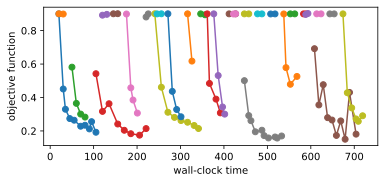

In [93]:
d2l.set_figsize([6, 2.5])
results = e.results

for trial_id in results.trial_id.unique():
    df = results[results['trial_id'] == trial_id]
    d2l.plt.plot(
        df['st_tuner_time'],
        df['validation_error'],
        marker='o'
    )

d2l.plt.xlabel('wall-clock time')
d2l.plt.ylabel('objective function')